# Movie records

![Cine](img/cine.jpg)

$^{1}$Photo of the local cinema taken from [Zelai Arizti](https://www.zelaiarizti.eus/eu/gela-erreserbak).

Feb, 2024
> *Data mining with API, Data Analysis*

## Background
For a little over a decade, I've been keeping a record of the movies I watch, both in theaters and at home. I jot down the title, director, release year, and rate them with stars based on how I felt about them. In reality, my rating system consists of just two numbers: I give 4 stars if I liked the movie and 5 if I loved it. If a movie didn't evoke any special feelings, I leave the rating box blank. This dataset now has almost a thousand entries, and I've thought about analyzing it to answer some questions I have.

For instance, lately I've had the feeling that movies are getting longer. Is this true, or is it just my impression? To get the duration in minutes for each film and integrate it into my table, I thought about using the API of the online movie database [TMDB](https://www.themoviedb.org/) (The Movie Database). Once connected to it, besides the runtime, I could also complete the information, for example, with the ratings received by each movie and compare my tastes with those of the community.

In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TMDB API wrapper
import tmdbsimple as tmdb

# More packages
from iso639 import Lang
import warnings

## The data
To simplify the code and facilitate access, I found the following library for the TMDB API: [tmdbsimple](https://github.com/celiao/tmdbsimple). It has a function that utilizes the movie search utility based on its title. In my table, the movie titles are often in Spanish, and this function finds the closest match in the TMBD database. To fine-tune the results, I include the movie's release year in the search.

Next, once the movie identifier is found, I access the movie record so I can get the following information:
- `tmdb_id`: film TMDB identifier.
- `tmdb_title`: title given in TMDB (normaly the English one).
- `tmdb_genre`: here I filter the response to differentiate between *documentaries* and just *films* (fiction films). 
- `tmdb_lang`: original language.
- `tmdb_runtime`: duration of the film in minutes.
- `tmdb_vote_cnt`: number of ratings.
- `tmdb_vote_avg`: average rating.

In [2]:
# Init TMDB API parameters
tmdb.API_KEY = "api-key"
tmdb.REQUESTS_TIMEOUT = 5  # seconds, for both connect and read

# Read from file my movie records
films = pd.read_csv('data/films.csv', usecols=['title', 'director', 'year', 'stars'])
films

,title,director,year,stars
0,Inland Empire,David Lynch,2006,4.0
1,La vida es un milagro,Emir Kusturica,2004,NaN
2,El arca rusa,Aleksandr Sokurov,2002,5.0
3,Biutiful,Alejandro Glez. Iñárritu,2010,NaN
4,Carretera perdida,David Lynch,1997,NaN
...,...,...,...,...
928,Anatomía de una caída,Justine Triet,2023,4.0
929,Fallen Leaves,Aki Kaurismäki,2023,4.0
930,Chinas,Arantxa Echevarría,2023,NaN
931,Una habitación con vistas,James Ivory,1985,NaN


In [3]:
# ****SEARCH MOVIE****

# Init Search method
search = tmdb.Search()

# Iterate through my records' title and year to find TMDB id
tmdb_ids = []
tmdb_titles = []

for row in range(len(films)):
    
    response = search.movie(query=films.loc[row, 'title'],
                            year=films.loc[row, 'year'])

    # Iterate through the possible movies
    ids = []
    titles = []
    for i in range(len(response['results'])):
        ids.append(response['results'][i]['id'])
        titles.append(response['results'][i]['title'])

    # I will take the most probable film found, first in the list
    try:
        tmdb_ids.append(ids[0])
        tmdb_titles.append(titles[0])
    except:
        tmdb_ids.append("")
        tmdb_titles.append("")


# Assign new columns to the dataframe    
films['tmdb_title'] = tmdb_titles
films['tmdb_id'] = tmdb_ids



# ****GET MOVIE INFO****

# Iterate through the films to fetch the required info
tmdb_genres = []
tmdb_langs = []
tmdb_runtimes = []
tmdb_vote_cnts = []
tmdb_vote_avgs = []

for row in range(len(films)):

    movie = tmdb.Movies(films.loc[row, 'tmdb_id'])

    # Get genres distinguishing Documentaries from Films
    try:
        tmdb_genre = 'Film'
        for genre in movie.info()['genres']:
            if genre['name'] == 'Documentary':
                tmdb_genre = 'Documentary'
        tmdb_genres.append(tmdb_genre)
    except:
        tmdb_genres.append("")

    # Get the language
    try:
        tmdb_langs.append(movie.info()['original_language'])
    except:
        tmdb_langs.append("")

    # Get the runtime
    try:
        tmdb_runtimes.append(movie.info()['runtime'])
    except:
        tmdb_runtimes.append("")

    # Get the rating counts
    try:
        tmdb_vote_cnts.append(movie.info()['vote_count'])
    except:
        tmdb_vote_cnts.append("")

    # Get the rating
    try:
        tmdb_vote_avgs.append(movie.info()['vote_average'])
    except:
        tmdb_vote_avgs.append("")
    

# Assign new columns to the dataframe  
films['tmdb_genre'] = tmdb_genres
films['tmdb_lang'] = tmdb_langs
films['tmdb_runtime'] = tmdb_runtimes
films['tmdb_vote_cnt'] = tmdb_vote_cnts
films['tmdb_vote_avg'] = tmdb_vote_avgs

# Print the dataframe
films

,title,director,year,stars,tmdb_title,tmdb_id,tmdb_genre,tmdb_lang,tmdb_runtime,tmdb_vote_cnt,tmdb_vote_avg
0,Inland Empire,David Lynch,2006,4.0,Inland Empire,1730,Film,en,180,1007,7.023
1,La vida es un milagro,Emir Kusturica,2004,NaN,Life Is a Miracle,20128,Film,sr,155,163,7.365
2,El arca rusa,Aleksandr Sokurov,2002,5.0,Russian Ark,16646,Film,ru,99,425,7.3
3,Biutiful,Alejandro Glez. Iñárritu,2010,NaN,Biutiful,45958,Film,es,148,1040,7.255
4,Carretera perdida,David Lynch,1997,NaN,Lost Highway,638,Film,en,134,2421,7.575
...,...,...,...,...,...,...,...,...,...,...,...
928,Anatomía de una caída,Justine Triet,2023,4.0,Anatomy of a Fall,915935,Film,fr,152,891,7.744
929,Fallen Leaves,Aki Kaurismäki,2023,4.0,Fallen Leaves,986280,Film,fi,81,267,7.249
930,Chinas,Arantxa Echevarría,2023,NaN,Chinas,1034387,Film,es,119,7,7.643
931,Una habitación con vistas,James Ivory,1985,NaN,A Room with a View,11257,Film,en,117,690,6.988


In [48]:
# Save data into a file
films.to_csv('data/films-tmdb.csv')

# Read from file
films = pd.read_csv('data/films-tmdb.csv', index_col=False)

# Get dataframe info
films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.2   927 non-null    int64  
 1   Unnamed: 0.1   927 non-null    int64  
 2   Unnamed: 0     927 non-null    int64  
 3   title          927 non-null    object 
 4   director       927 non-null    object 
 5   year           927 non-null    int64  
 6   stars          927 non-null    object 
 7   tmdb_title     927 non-null    object 
 8   tmdb_id        927 non-null    int64  
 9   tmdb_genre     927 non-null    object 
 10  tmdb_lang      927 non-null    object 
 11  tmdb_runtime   927 non-null    int64  
 12  tmdb_vote_cnt  927 non-null    int64  
 13  tmdb_vote_avg  927 non-null    float64
dtypes: float64(1), int64(7), object(6)
memory usage: 101.5+ KB


## Data validation
Missing values in the `tmdb_` columns indicate that the film was not found in TMDB, so I discard those rows altogether since there is no information available for them.
Furthermore, I adjust the data types for integers (id, runtime, number of ratings) and categorize the genre, language, and the number of stars that I assign. In the latter case, 4 stars become "liked," 5 stars become "loved," and missing values are classified as "untagged."

In [32]:
# Drop films that were not found in TMDB
films = films.dropna(subset='tmdb_id')

# Convert to integer data types
films['tmdb_id'] = films['tmdb_id'].astype('int64')
films['tmdb_runtime'] = films['tmdb_runtime'].astype('int64')
films['tmdb_vote_cnt'] = films['tmdb_vote_cnt'].astype('int64')

# Round rating values
films['tmdb_vote_avg'] = round(films['tmdb_vote_avg'], 1)

# Categorize "stars", my personal preferences, as follows
films['stars'] = films['stars'].fillna(0).replace({5: 'loved', 4: 'liked', 0: 'untagged'}).astype('category')

# Categorize genre elements: Film, Documentary.
films['tmdb_genre'] = films['tmdb_genre'].astype('category')

# Categorize languages
films['tmdb_lang'] = films['tmdb_lang'].astype('category')

# Get dataframe info
films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 927 entries, 0 to 932
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Unnamed: 0     927 non-null    int64   
 1   title          927 non-null    object  
 2   director       927 non-null    object  
 3   year           927 non-null    int64   
 4   stars          927 non-null    category
 5   tmdb_title     927 non-null    object  
 6   tmdb_id        927 non-null    int64   
 7   tmdb_genre     927 non-null    category
 8   tmdb_lang      927 non-null    category
 9   tmdb_runtime   927 non-null    int64   
 10  tmdb_vote_cnt  927 non-null    int64   
 11  tmdb_vote_avg  927 non-null    float64 
dtypes: category(3), float64(1), int64(5), object(3)
memory usage: 76.7+ KB


## Duration of the films
Let's first analyze the duration of the movies. A histogram will provide us with their distribution.

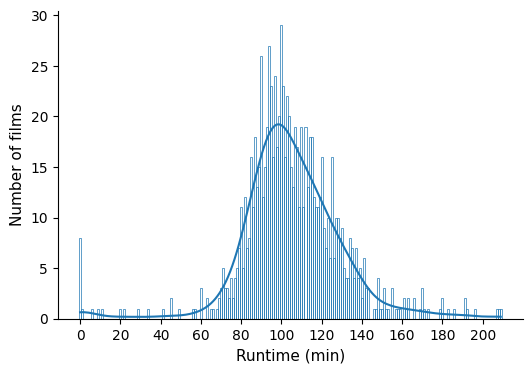

In [33]:
# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(films['tmdb_runtime'], ax=ax, stat="count",
             discrete=True, fill=False, kde=True)

ax.set_xlabel("Runtime (min)", fontsize=11)
ax.set_ylabel("Number of films", fontsize=11)
ax.set_xticks(range(0, 220, 20), labels=list(np.arange(0, 220, 20)))
sns.despine()

plt.show()

We see that there are about 8 movies with a duration of 0 minutes. This is because the value of this field was not filled in the TMDB record, so we discard them before calculating the average duration value of the films.

In [34]:
# Remove records with runtime 0
films_t = films.loc[films['tmdb_runtime'] > 0, :]

# Print mean value
print(f"Mean duration is --> {films_t['tmdb_runtime'].mean():.0f} minutes")

Mean duration is --> 106 minutes


Therefore, the average duration of a feature film is approximately one hour and three quarters, which matches the idea I had.

Out of curiosity, I extract the ten longest movies from those I have seen.

In [35]:
# Define list with columns to show
show_cols = ['director', 'year', 'tmdb_title', 'tmdb_runtime']

# Print ten most lengthy movies
films_t.loc[:, show_cols]\
            .sort_values(by=['tmdb_runtime'], ascending=False).head(10)

,director,year,tmdb_title,tmdb_runtime
801,Martin Scorsese,2019,The Irishman,209
655,Martin Scorsese,2005,No Direction Home: Bob Dylan,208
139,Akira Kurosawa,1954,Seven Samurai,207
511,Nuri Bilge Ceylan,2014,Winter Sleep,196
299,Robert B. Weide,2012,Woody Allen: A Documentary,192
607,Richard Attenborough,1982,Gandhi,191
180,Marcel Carné,1945,Children of Paradise,191
30,Luchino Visconti,1963,The Leopard,186
259,Andrei Tarkovsky,1966,Andrei Rublev,183
0,David Lynch,2006,Inland Empire,180


Next, I plot the movies based on their duration, distinguishing between documentaries and fiction films on the graph. I include the yearly mean value on the graph as well.

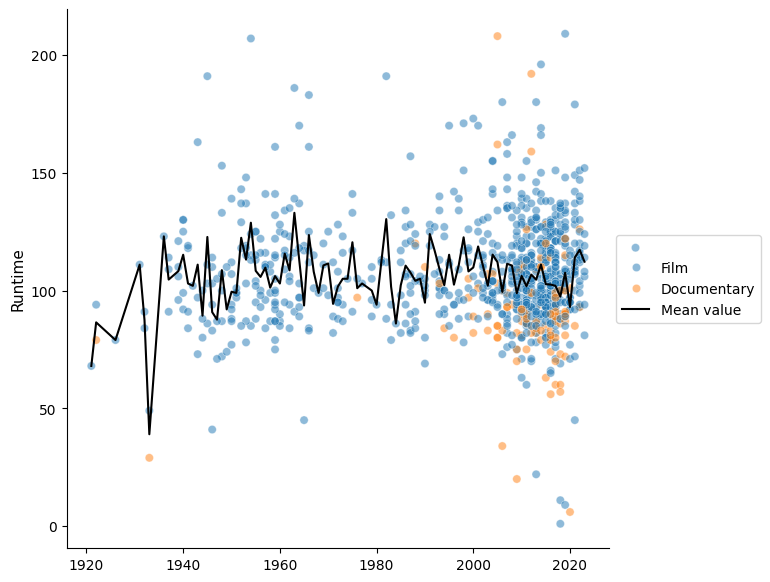

In [36]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))


sns.scatterplot(x="year", y="tmdb_runtime", data=films_t, ax=ax, alpha=0.5,
                hue="tmdb_genre", hue_order=['Film', 'Documentary'])

films_t.pivot_table(index='year', values='tmdb_runtime', aggfunc='mean').plot(ax=ax, color='black')

ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Runtime", fontsize=11)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=10,
          labels=['', 'Film', 'Documentary', 'Mean value'])
sns.despine()

plt.show()

In the graph, it can be observed that the majority of the movies I have seen are from recent years. Regarding their duration, it does not seem to have increased. However, I am going to focus the graph on the last 20 years, from 2004 to 2024, and I am going to exclude the documentaries to see if there is an upward trend in duration or if such a trend does not exist.

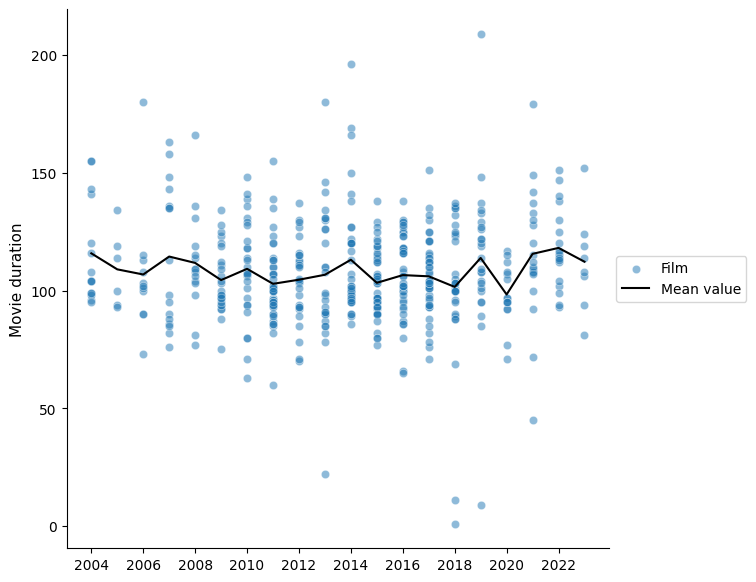

In [37]:
# Define cut-off year
y = 2004

# Get only films in the last "y" years and not documentaries
films_ty = films_t.loc[(films_t['year'] >= y) & (films_t['tmdb_genre'] == 'Film'), :]

# Plot
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x="year", y="tmdb_runtime", data=films_ty, ax=ax, alpha=0.5)

films_ty.pivot_table(index='year', values='tmdb_runtime', aggfunc='mean').plot(ax=ax, color='black')

ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Movie duration", fontsize=11)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=10, labels=['Film', 'Mean value'])
ax.set_xticks(range(2004, 2024, 2), labels=list(np.arange(2004, 2024, 2)))
sns.despine()

plt.show()

I would say there hasn't been a significant change in the duration of the movies, at least in the ones I've seen, so the notion that movies are getting longer must be just my impression that doesn't align with reality.

## Rating analysis
To ensure consistency in the movie ratings, I will only consider movies that have received a minimum of, for example, 100 ratings.

In [38]:
# Minimum number of votings to consider movie rating valid
v = 100

# Get films with at least 100 votes
films_v = films.loc[films['tmdb_vote_cnt'] >= v, :]

# Print how many of them there are
print(f"{len(films_v)} out of the {len(films)} movies have more than {v} votes in TMDb")

648 out of the 927 movies have more than 100 votes in TMDb


These are the 10 movies that have received the most number of ratings:

In [39]:
# Define list of columns to show
show_cols = ['director', 'year', 'tmdb_title', 'tmdb_vote_cnt', 'tmdb_vote_avg']

# Print most voted movies
films_v.loc[:, show_cols]\
            .sort_values(by=['tmdb_vote_cnt'], ascending=False).head(10)

,director,year,tmdb_title,tmdb_vote_cnt,tmdb_vote_avg
468,Christopher Nolan,2014,Interstellar,33560,8.4
792,Todd Phillips,2019,Joker,24052,8.2
618,Pete Docter,2015,Inside Out,19980,7.9
818,Joon-ho Bong,2019,Parasite,17053,8.5
627,Denis Villeneuve,2016,Arrival,16925,7.6
919,Olivier Nakache,2011,The Intouchables,16497,8.3
539,Morten Tyldum,2014,The Imitation Game,16308,8.0
580,Damien Chazelle,2016,La La Land,15977,7.9
650,Christopher Nolan,2017,Dunkirk,15790,7.5
577,Hayao Miyazaki,2001,Spirited Away,15486,8.5


And these are the ones that have received the highest ratings:

In [40]:
# Print most rated movies
films_v.loc[:, show_cols]\
            .sort_values(by=['tmdb_vote_avg'], ascending=False).head(10)

,director,year,tmdb_title,tmdb_vote_cnt,tmdb_vote_avg
818,Joon-ho Bong,2019,Parasite,17053,8.5
577,Hayao Miyazaki,2001,Spirited Away,15486,8.5
816,Isao Takahata,2003,Grave of the Fireflies,5086,8.5
442,Giuseppe Tornatore,1988,Cinema Paradiso,4107,8.5
34,Sergio Leone,1966,"The Good, the Bad and the Ugly",8060,8.5
139,Akira Kurosawa,1954,Seven Samurai,3389,8.5
426,Milos Forman,1975,One Flew Over the Cuckoo's Nest,9920,8.4
468,Christopher Nolan,2014,Interstellar,33560,8.4
489,Damien Chazelle,2014,Whiplash,14322,8.4
409,Carlos Sorin,2008,Rear Window,6115,8.4


For a clearer visual reference, I place these movies into three different groups corresponding to my personal ratings of them.

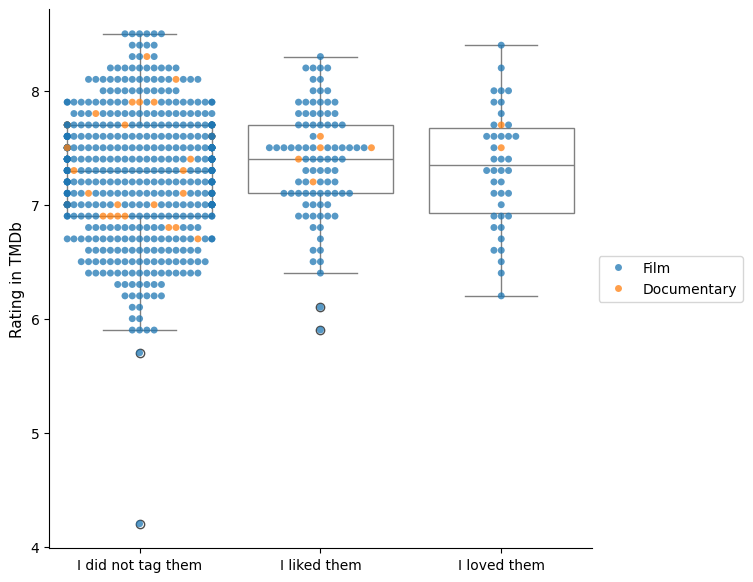

In [41]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))

warnings.filterwarnings('ignore') # swarmplot does not fit, but ignore warning
sns.swarmplot(ax=ax, x="stars", y="tmdb_vote_avg", data=films_v, alpha=0.75,
              order=['untagged', 'liked', 'loved'],
              hue="tmdb_genre", hue_order=['Film', 'Documentary'])

sns.boxplot(ax=ax, x="stars", y="tmdb_vote_avg", data=films_v,
              boxprops=dict(linewidth=1, facecolor='white', edgecolor='grey', alpha=1),
                whiskerprops=dict(linewidth=1, color='grey', alpha=1),
                medianprops=dict(linewidth=1, color="grey", alpha=1),
                capprops=dict(linewidth=1, color='grey', alpha=1)
)

ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Rating in TMDb", fontsize=11)
ax.set_xticks(range(3), labels=['I did not tag them',
                                'I liked them', 'I loved them'])
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=10)
sns.despine()

plt.show()

In the graph, I see that among the ones I loved, there are a couple of movies that also enjoyed much public favor. Which ones are they?

In [42]:
# Append my valoration to print
show_cols.append('stars')

# Show maximum rating movies among loved ones
films_v.loc[films_v['stars'] == 'loved', show_cols]\
            .sort_values(by='tmdb_vote_avg', ascending=False).head(2)

,director,year,tmdb_title,tmdb_vote_cnt,tmdb_vote_avg,stars
426,Milos Forman,1975,One Flew Over the Cuckoo's Nest,9920,8.4,loved
193,Billy Wilder,1960,The Apartment,2102,8.2,loved


Oh, definitely!

Which is that film that I loved, but got a lower rating in TMDB?

In [43]:
# Show the movie with less rating among the loved ones
films_v.loc[films_v['stars'] == 'loved', show_cols]\
            .sort_values(by='tmdb_vote_avg').head(1)

,director,year,tmdb_title,tmdb_vote_cnt,tmdb_vote_avg,stars
658,Manuel Martín Cuenca,2017,The Motive,257,6.2,loved


And what about the movies that I didn't label because they didn't particularly strike me (or I forgot to label them), yet they have high ratings? I list the six that appear at the top of the graph in the untagged group.

In [44]:
# Show maximum rating movie among untagged ones
films_v.loc[films_v['stars'] == 'untagged', show_cols]\
            .sort_values(by='tmdb_vote_avg', ascending=False).head(6)

,director,year,tmdb_title,tmdb_vote_cnt,tmdb_vote_avg,stars
818,Joon-ho Bong,2019,Parasite,17053,8.5,untagged
139,Akira Kurosawa,1954,Seven Samurai,3389,8.5,untagged
816,Isao Takahata,2003,Grave of the Fireflies,5086,8.5,untagged
577,Hayao Miyazaki,2001,Spirited Away,15486,8.5,untagged
34,Sergio Leone,1966,"The Good, the Bad and the Ugly",8060,8.5,untagged
442,Giuseppe Tornatore,1988,Cinema Paradiso,4107,8.5,untagged


I definitely should have uprated Parasite! (But by no means Cinema Paradiso).

And what's that movie that's so low in the ratings?

In [45]:
# Show that outlier among untagged ones
films_v.loc[films_v['stars'] == 'untagged', show_cols]\
            .sort_values(by='tmdb_vote_avg').head(1)

,director,year,tmdb_title,tmdb_vote_cnt,tmdb_vote_avg,stars
142,Ed. Wood,1959,Plan 9 from Outer Space,509,4.2,untagged


It's the famous Ed Wood movie, considered to be the worst in the history of cinema!

## Original languages
Once we're in the thick of it, I found it interesting to consider the original language of the movies I've watched over these years. Perhaps this information would tell me something about the type of cinema I prefer.

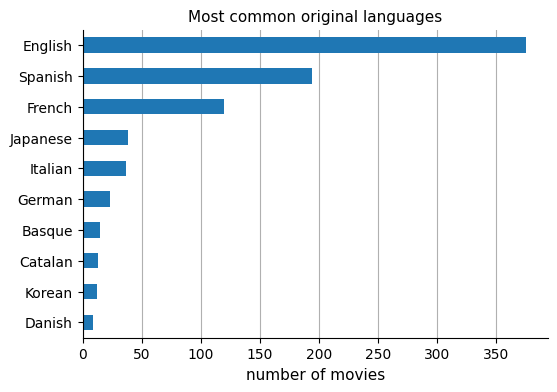

In [46]:
# Define number of languages
n = 10

# Get the n most frequent languages
films_nlang = films.value_counts('tmdb_lang').head(n)

# Convert their language codes into full names
films_nlang = films_nlang.reset_index()
films_nlang['tmdb_lang'] = [Lang(s).name for s in films_nlang['tmdb_lang']]
films_nlang = films_nlang.set_index('tmdb_lang')

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

films_nlang.plot(ax=ax, kind="barh")

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.set_title("Most common original languages", size=11)
ax.set_xlabel("number of movies", fontsize=11)
ax.set_ylabel("", fontsize=11)
ax.legend().set_visible(False)
ax.invert_yaxis()
sns.despine()

plt.show()

The top three main languages were as expected, and so were the following ones. As Korean and Danish appear on this list, it confirms the special interest I have in the cinema of these countries.

## Conclusion

This little project allowed me to analyze the personal movie record I've been updating for some years. I found it interesting to have the option to automatically add further data of each movie from TMDB, as it saves me the trouble of doing it manually, and my table has indeed become more comprehensive.

Regarding the questions I had in mind, it seems that the duration of the films does not tend to increase, at least not significantly, after an analysis that has been purely visual.

As for the community ratings and whether they are in line with my tastes, well, it's a bit of everything. However, one thing that is clear is that TMDB ratings don't help much in identifying good movies since the vast majority fall between 6 and 8 points. However, they do help in recognizing big hits based on the number of ratings.